<h1><center>Weather or Not, There is Crime</center></h1>
<center>
    <i>Jason Stock, Tom Cavey, Amber Lee<br/> 
    Relationships between crime and weather patterns in Chicago</i>
</center>

---

In [1]:
import presentation_soln as soln

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

# IMPORTANCE
---
- There are 6.72 million crimes committed from 2001 to 2018
- The City of Chicago Police Department consists of 12,244 officers and 1,925 employees
- Chicago is a large city with unique neighborhoods defined by social-economic factors
- Variance in weather conditions may effect crime rates throughout the city  
- Provide a model to predict crime for each district and allocate resources preemptively

<img src="https://docs.google.com/uc?export=download&id=11zymUMWn0GdZFGWUuachHsLdZ6M16Bmj" width="40%">
<h4><center>[6] Chicago Neighborhoods</center></h4>

# DATA
---
- Eight files of Local Climatological Data from the National Oceanic Atmospheric Administration
- Data pulled from four various weather stations

In [2]:
soln.weather_head()

,STATION,STATION_NAME,ELEVATION,LATITUDE,LONGITUDE,DATE,REPORTTPYE,HOURLYSKYCONDITIONS,HOURLYVISIBILITY,HOURLYPRSENTWEATHERTYPE,HOURLYDRYBULBTEMPF,HOURLYDRYBULBTEMPC,HOURLYWETBULBTEMPF,HOURLYWETBULBTEMPC,HOURLYDewPointTempF,HOURLYDewPointTempC,HOURLYRelativeHumidity,HOURLYWindSpeed,HOURLYWindDirection
0,WBAN:04838,CHICAGO PALWAUKEE AIRPORT IL US,193.9,42.12083,-87.90472,2015-01-02 00:52,FM-15,CLR:00,10.0,NaN,25,-3.9,23,-5.3,17,-8.3,72,5,270


- A 1.6 GB file reporting on every crime reported from January 2001 to present in Chicago
- Data is extracted from the Chicago Police Department’s Citizen Law Enforcement Analysis and Reporting system 

In [3]:
soln.crime_head()

,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,...,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location
0,10000092,HY189866,03/18/2015 07:44:00 PM,047XX W OHIO ST,041A,BATTERY,AGGRAVATED: HANDGUN,STREET,False,False,...,28,25,04B,1144606,1903566,2015,02/10/2018 03:50:01 PM,41.891399,-87.744385,"(41.891398861, -87.744384567)"


- Aggregated the data by day and by week to use for machine learning models

In [4]:
soln.data_tail()

,date,dry,wet,wind,humidity,district,homicide,robbery,battery,assault,burglary,theft,motor,weapons
930,2018041,72.037151,63.752218,10.343156,76.576722,5,2,30,102,45,17,91,14,6


# METHODOLOGY
---

- Linear Regression Algorithms used for predictive analysis
     - Scaled Conjugate Gradient (SCG), Stochastic Gradient Descent, Adam (PyTorch), Linear Regression, Ridge, Lasso, SVR (linear, polynomial, SBR), and BoostedTreeRegressor (CoreML)

# ANALYSIS
---
- Combination of boxplot and kernel density estimate for weather data

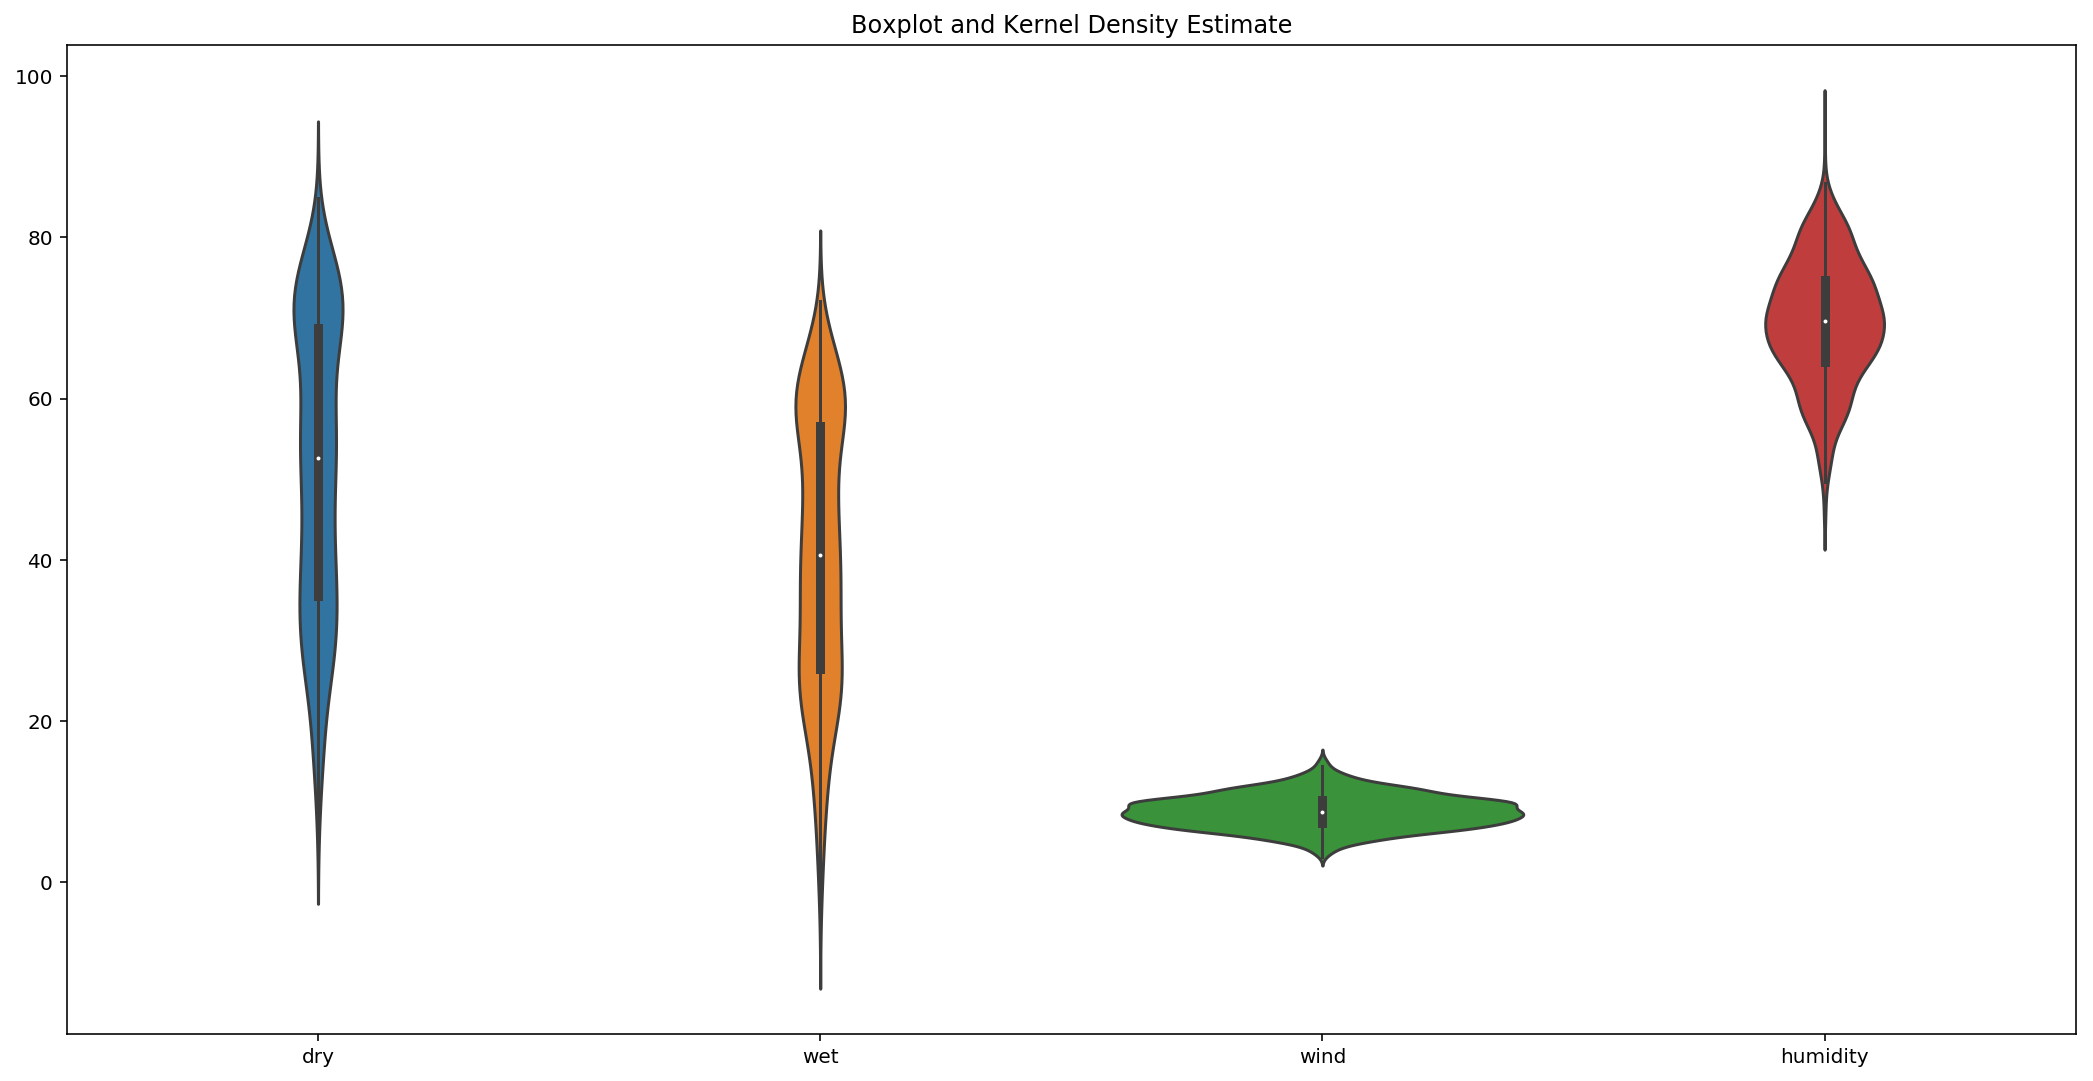

In [5]:
soln.feature_violin(1, range(1,5), 20, 2, 1)

- Some challenges...

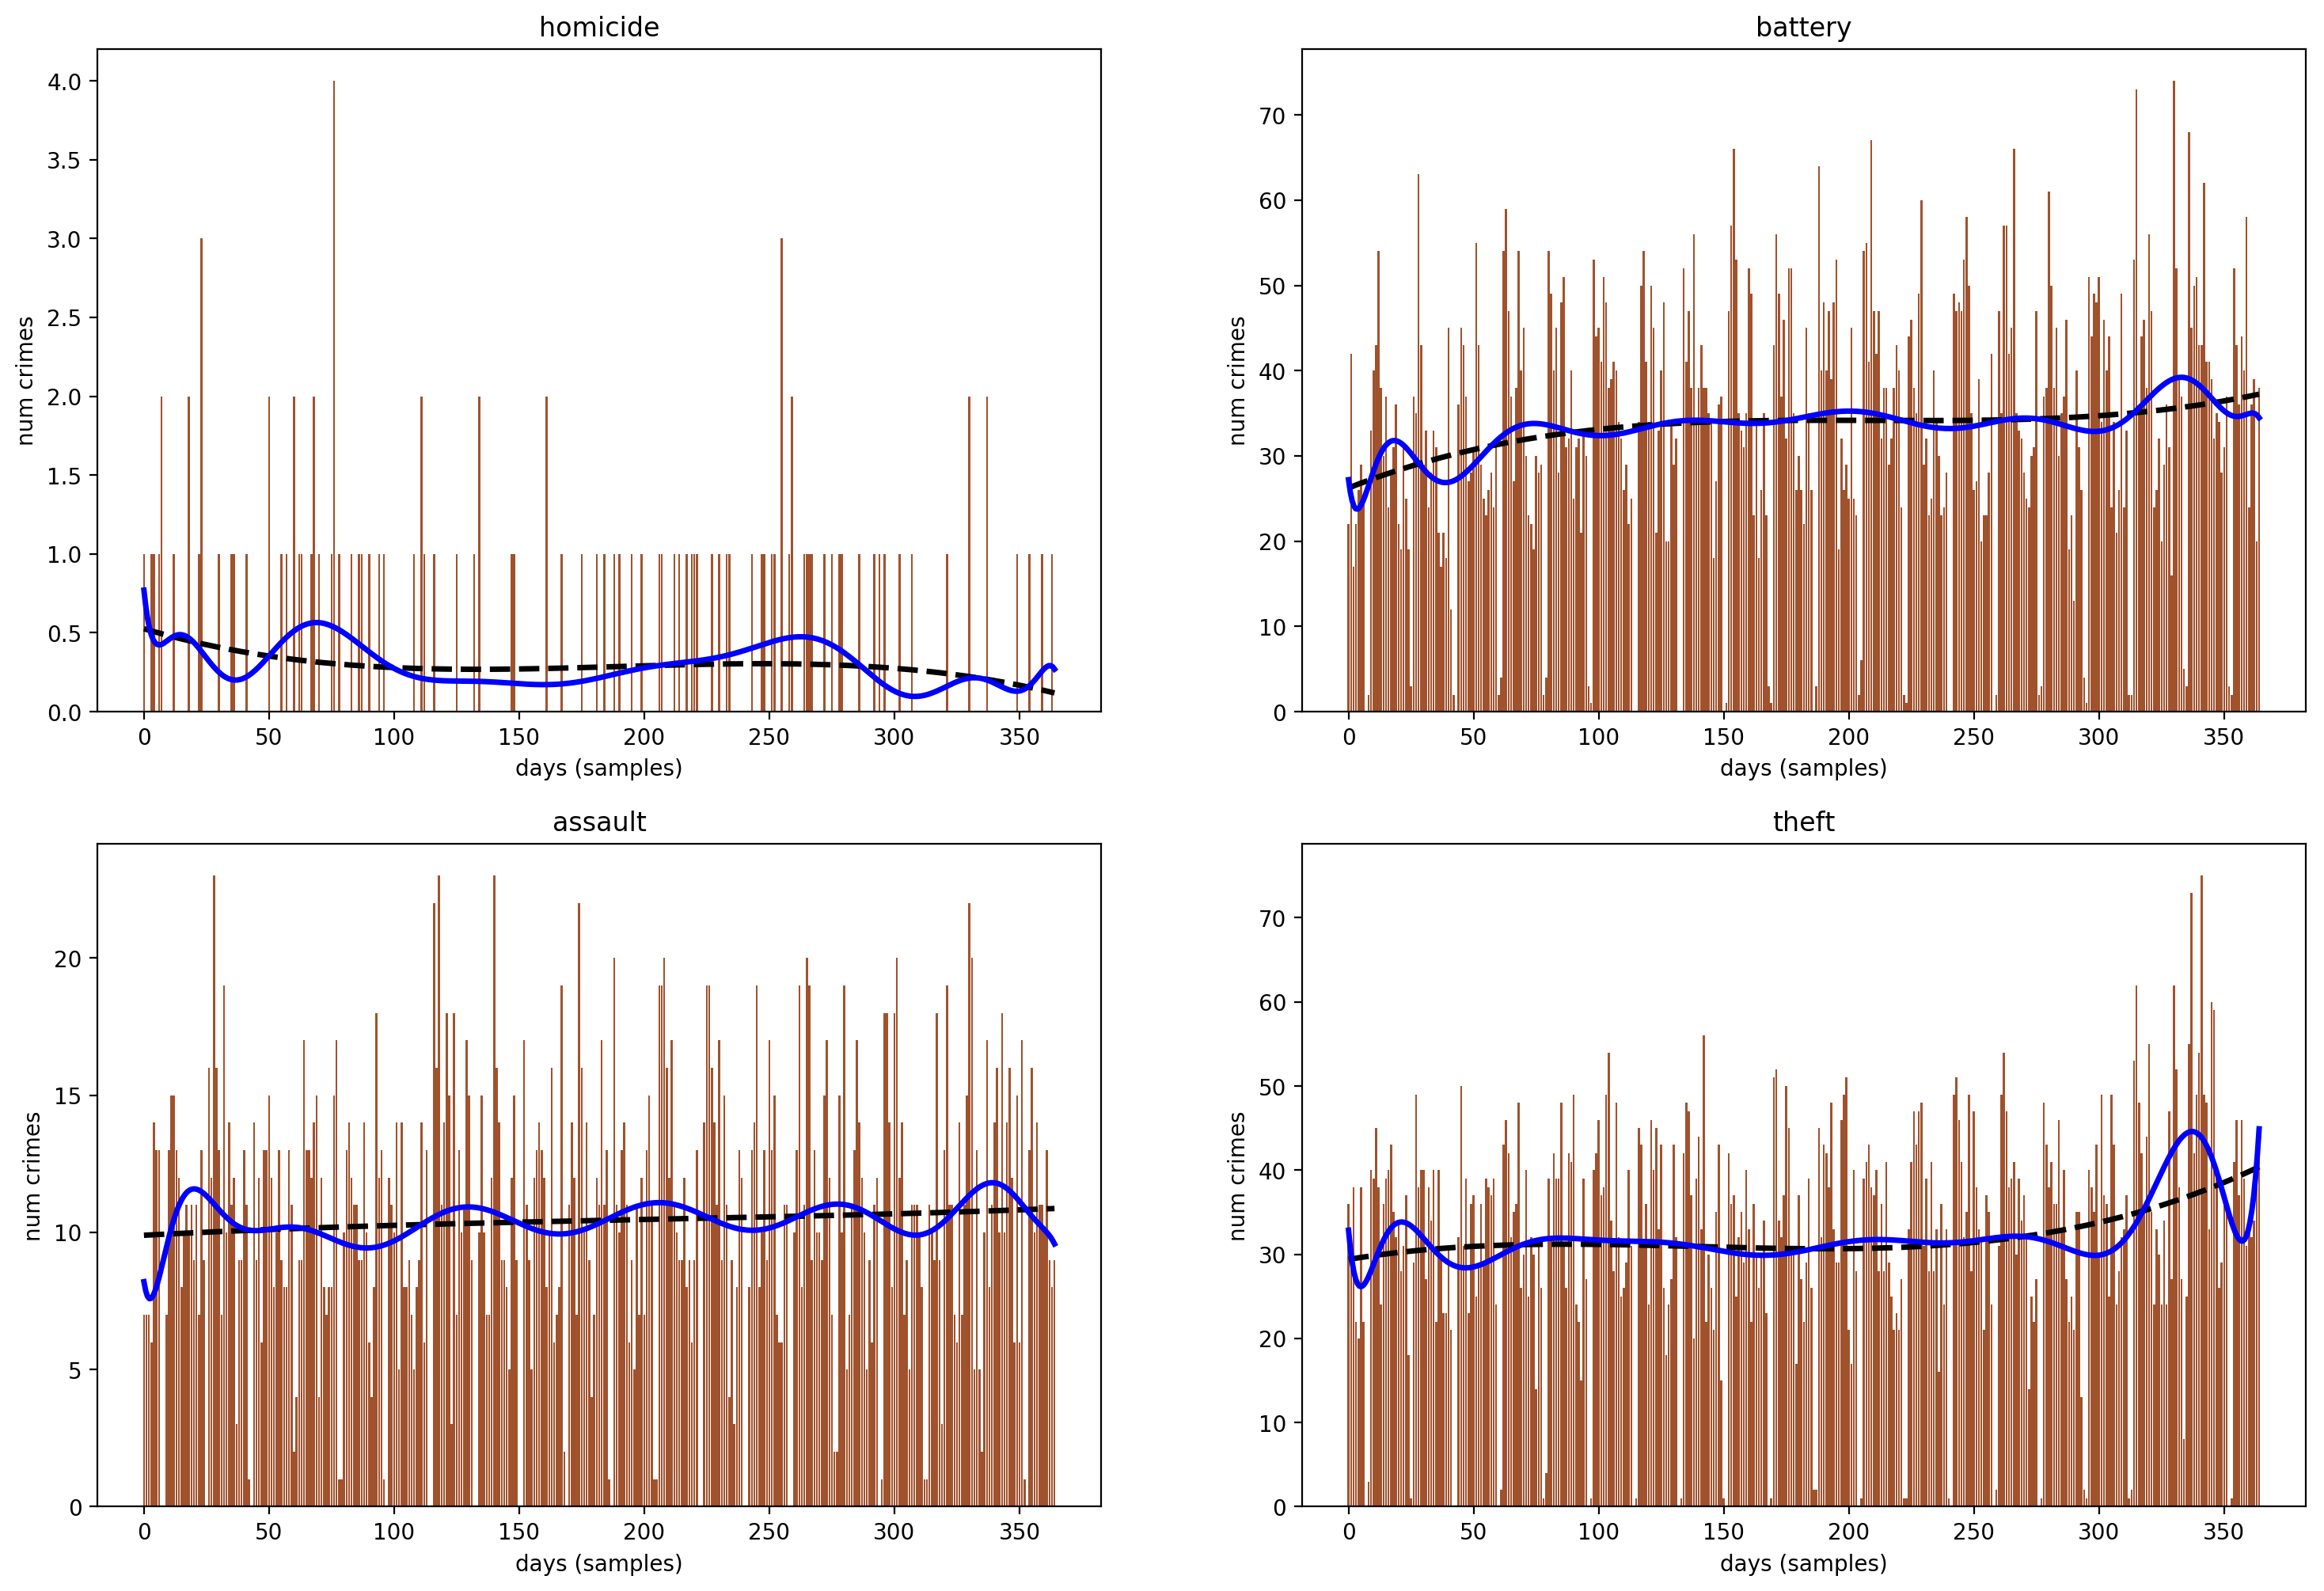

In [6]:
soln.bar_test(year=3, district='5', daily=True)

- Solution...

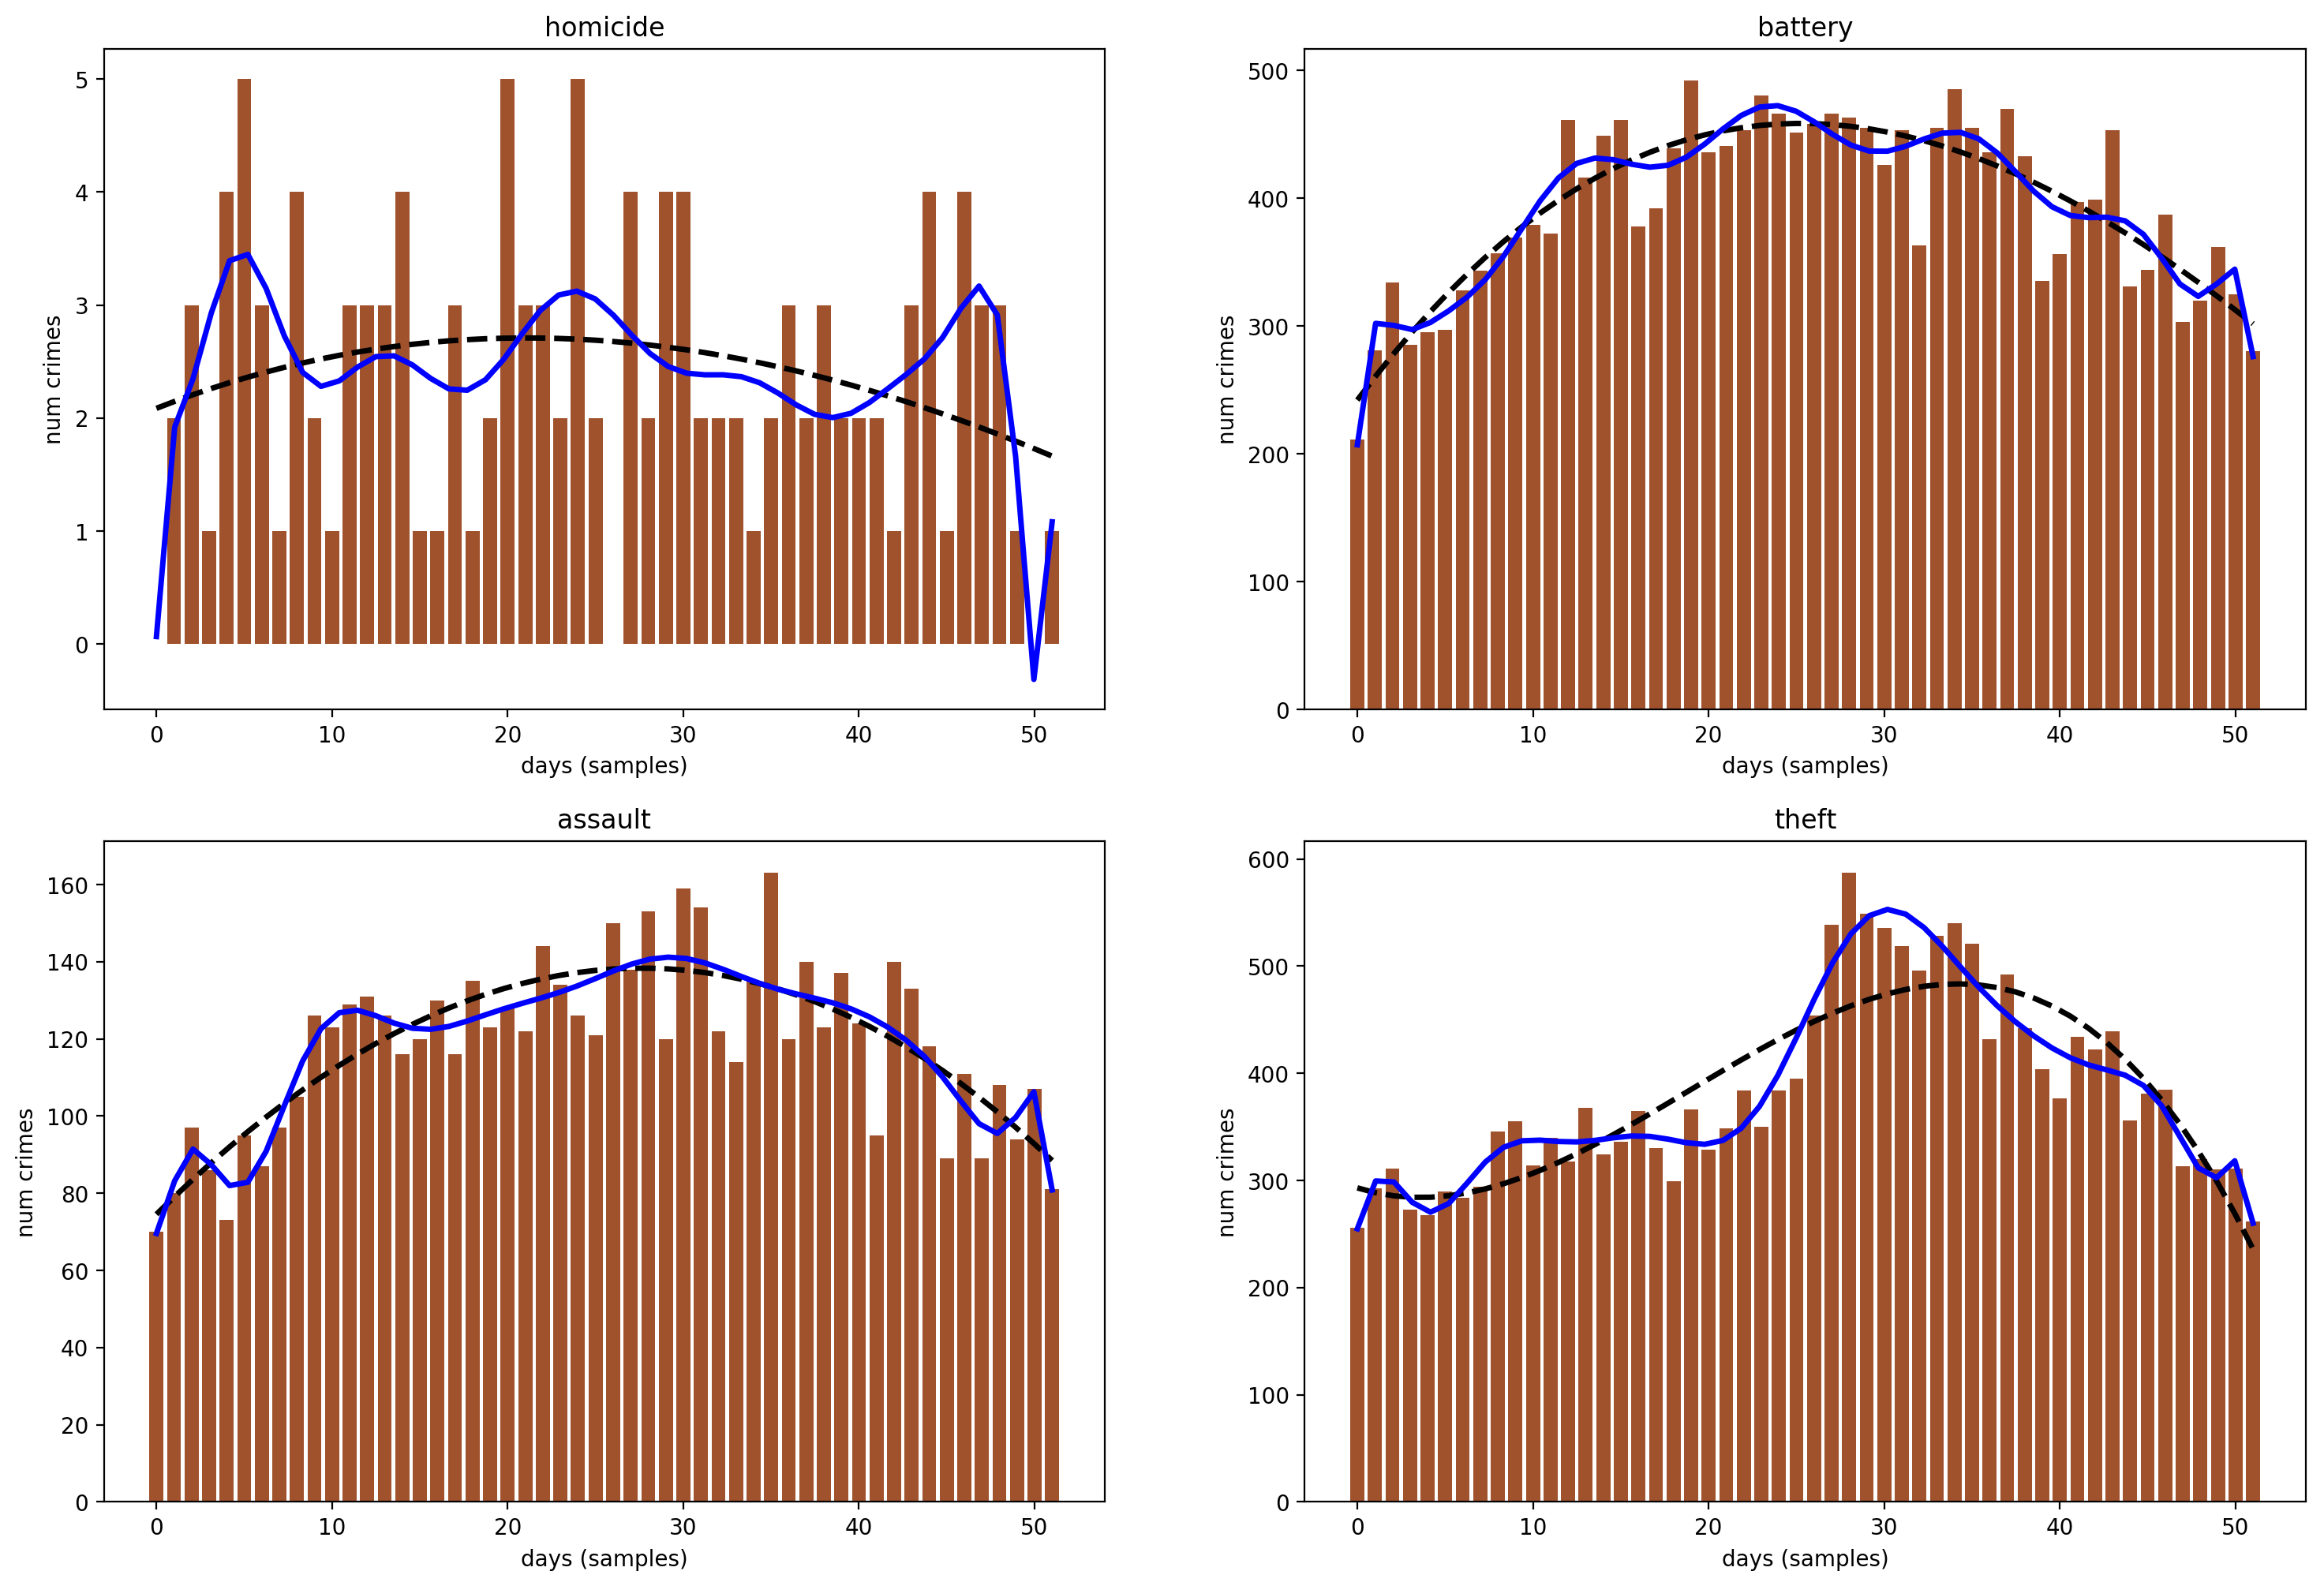

In [7]:
soln.bar_test(year=4, district='5', daily=False)

- Comparing various networks to find minimum error using Scaled Conjugate Gradient (SCG)
- Challenge of not overfitting the model

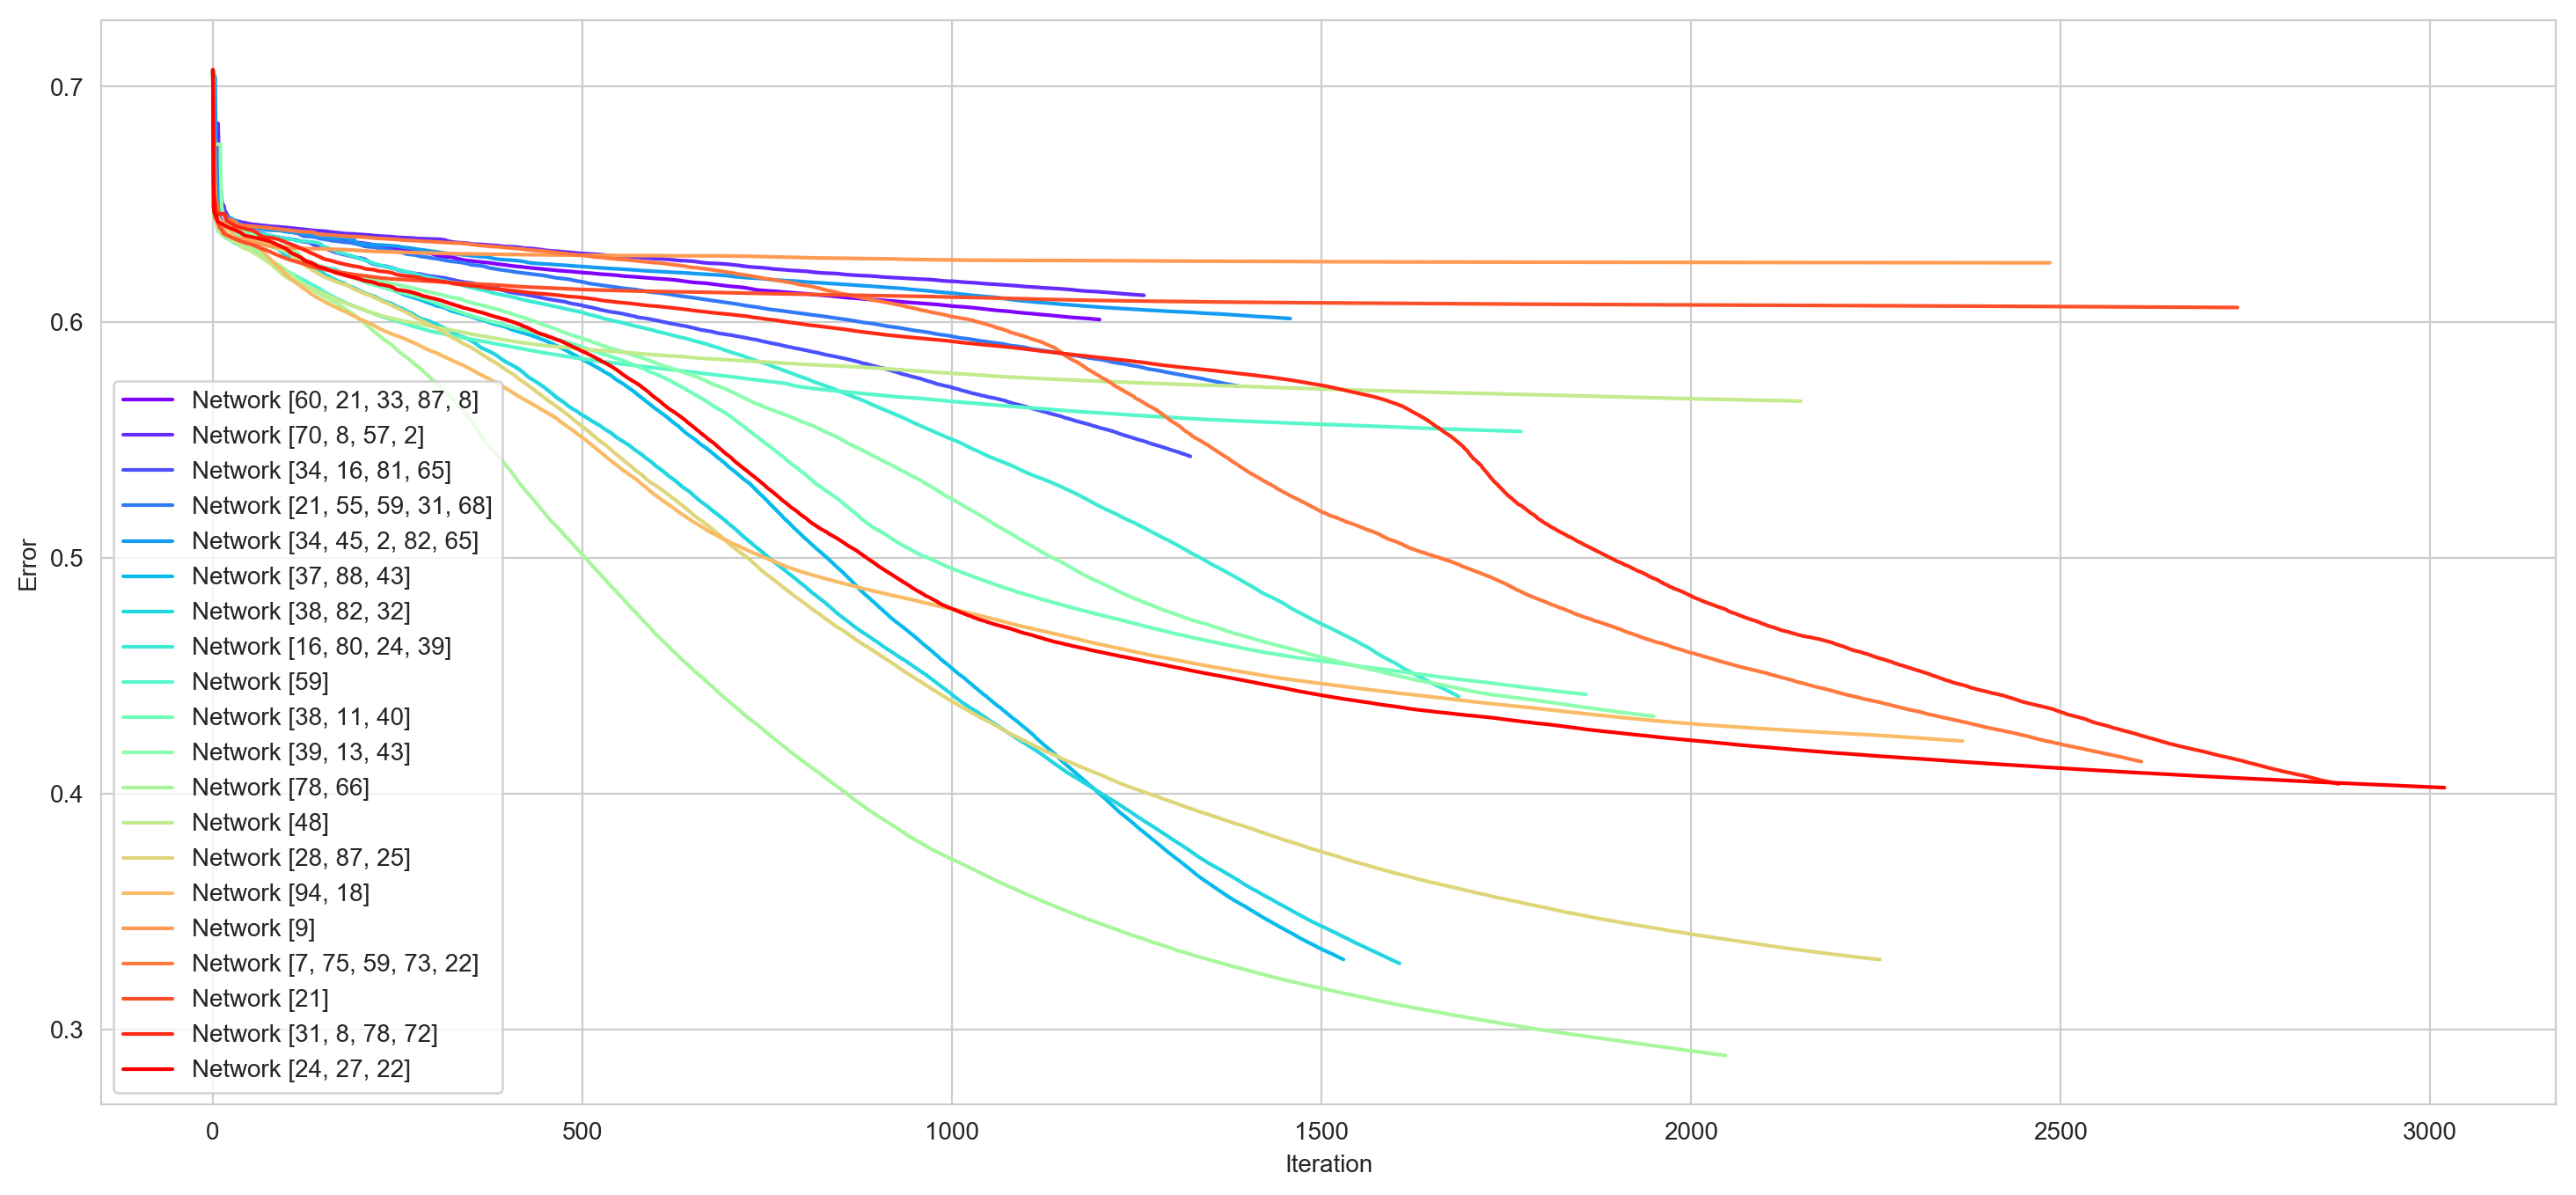

In [8]:
soln.network_test(district='5', ns=20)

# RESULTS
---
- Computed Pearson's Correlation Coefficient for each crime category per district
- Partial confident in predicting Assault, Theft, and Battery for the West side

<img src="https://docs.google.com/uc?export=download&id=1WYWkQW7QSs9lEUZyuNsnKDD_CIpZoCrF" width="80%">

# APPLICATION
---
- Ideal usage for predicting crime rates in the City of Chicago
- Save the trained model for future usage 

In [9]:
import dill
import numpy as np
import pandas as pd

'''Open the Predicitive Model'''
fp = open('trained_models.pickle', 'rb')
trained_models = dill.load(fp)
fp.close()

'''NEW Weekly Temperate Averages'''
dry_bulb_temp = 69.212739
wet_bulb_temp = 59.030585
wind_speed = 4.519358
relative_humidity = 72.286077

'''Display the Results'''
data = [dry_bulb_temp, wet_bulb_temp, wind_speed, relative_humidity]
trained_models.use(data, return_all=True, district=None)

| 1: Far North Side | 2:     North Side | 3:       N-W Side | 4:        Central | 5:      West Side 
| 6:       S-W Side | 7:     South Side | 8:   Far S-W Side | 9:  Far West Side |


,Homicide,Robbery,Battery,Assault,Burglary,Theft,Motor Theft,Weapons Assault
1,1,19,89,28,38,161,35,3
2,0,19,69,22,42,195,31,2
3,0,11,78,27,33,94,28,5
4,0,16,53,18,7,248,12,1
5,2,63,218,66,61,248,66,15
6,4,50,346,106,79,219,58,16
7,3,50,261,88,52,208,44,14
8,1,7,52,16,2,45,17,1
9,2,35,113,44,43,102,34,13


# CONCLUSION
---
- There was lots of interesting results, but the model is not as accurate as we had hoped
- Results showed correlations between weather and crime with confidence of 73 %
- Further analysis with more variables should be considered

# RESOURCES
---
- [6] Chicago Neighborhoods. (n.d.). Retrieved from http://www.thechicago77.com/ chicago-neighborhoods/